In [1]:
# Librerias basicas:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
import os
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from itertools import product

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")
seed(28)

Objetivo: dado alloy, area y thickness---> obtener: v,ramptime,holding time

In [2]:
df_autotreat = pd.read_csv("data_analyst.csv")
df_autotreat.head()

,Timestamp,Time,V,A,T,alloy,voltage,ramp_time,holding_time,area,Imax,modeling_thickness,final_thickness
0,1.687423e+09,2023-06-22 08:31:28,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
1,1.687423e+09,2023-06-22 08:31:29,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
2,1.687423e+09,2023-06-22 08:31:29,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
3,1.687423e+09,2023-06-22 08:31:30,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
4,1.687423e+09,2023-06-22 08:31:31,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514


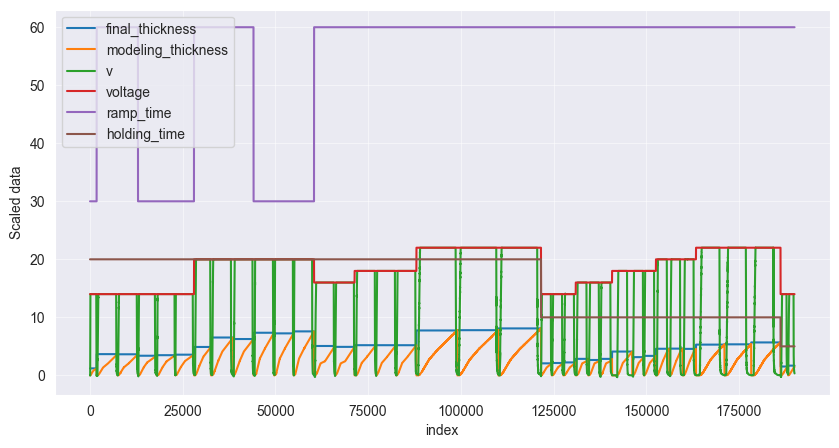

In [131]:
muesta_fin=190000
muestra_in=0
df_autotreat['final_thickness'].iloc[muestra_in:muesta_fin].plot(figsize=(10,5))
plt.plot(df_autotreat['modeling_thickness'].iloc[muestra_in:muesta_fin],label='modeling_thickness')
plt.plot(df_autotreat['V'].iloc[muestra_in:muesta_fin],label='v')
plt.plot(df_autotreat['voltage'].iloc[muestra_in:muesta_fin],label='voltage')
plt.plot(df_autotreat['ramp_time'].iloc[muestra_in:muesta_fin],label='ramp_time')
plt.plot(df_autotreat['holding_time'].iloc[muestra_in:muesta_fin],label='holding_time')
plt.grid(alpha=0.5, which='both')
plt.xlabel('index')
plt.ylabel('Scaled data')
plt.legend()
plt.show()

Voy a predecir con el estadistico VAR

In [104]:
X = df_autotreat[['V', 'A', 'T', 'voltage', 'ramp_time', 'holding_time', 'Imax']]
y = df_autotreat[['modeling_thickness']]
df_autotreat[['V', 'A', 'T', 'voltage', 'ramp_time', 'holding_time', 'Imax','modeling_thickness']].head()

,V,A,T,voltage,ramp_time,holding_time,Imax,modeling_thickness
0,0.03,0.00,38.1,14,30,20.0,0.53,0.0
1,0.03,0.00,38.1,14,30,20.0,0.53,0.0
2,0.03,0.01,38.1,14,30,20.0,0.53,0.0
3,0.03,0.00,38.1,14,30,20.0,0.53,0.0
4,0.03,0.00,38.1,14,30,20.0,0.53,0.0


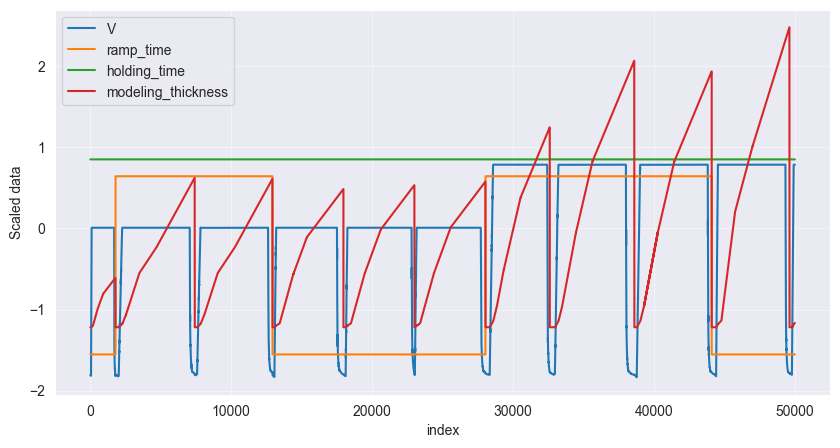

In [105]:
df_to_predict= df_autotreat[['V', 'ramp_time', 'holding_time','modeling_thickness']]
scaler = StandardScaler()

# Transform data
scaled_values = scaler.fit_transform(df_to_predict)

# Convert to dataframe
df_scaled = pd.DataFrame(scaled_values, 
                         columns=df_to_predict.columns, 
                         index=df_to_predict.index)

# Visualize data
df_scaled.iloc[:50000].plot(figsize=(10,5))
plt.grid(alpha=0.5, which='both')
plt.xlabel('index')
plt.ylabel('Scaled data')
plt.show()

In [113]:
new_df_scaled=df_scaled[['V', 'ramp_time','modeling_thickness']].iloc[:50000]
model = VAR(new_df_scaled)
optimal_lags = model.select_order()

print(f"The optimal lag order selected: {optimal_lags.selected_orders}")
#esto busca el lag mas efectivo

The optimal lag order selected: {'aic': 31, 'bic': 18, 'hqic': 20, 'fpe': 31}


In [107]:
lag_order = optimal_lags.selected_orders['bic']
results = model.fit(lag_order)

# Estimate the model (VAR) and show summary
var_model = results.model
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, Jan, 2024
Time:                     10:20:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.8790
Nobs:                     49982.0    HQIC:                  -23.8990
Log likelihood:           384888.    FPE:                4.13861e-11
AIC:                     -23.9081    Det(Omega_mle):     4.12497e-11
--------------------------------------------------------------------
Results for equation V
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.000046         0.000034            1.365           0.172
L1.V                           0.786309         0.004470          175.919           0.000
L1.ramp_time                

In [108]:
# Forecast 
horizon = 100
forecast = results.forecast(new_df_scaled.values[-lag_order:], steps=horizon)

# Convert to dataframe
df_forecast = pd.DataFrame(forecast, 
                           columns=new_df_scaled.columns, 
                           index=df_scaled.iloc[50000:50000+horizon].index)

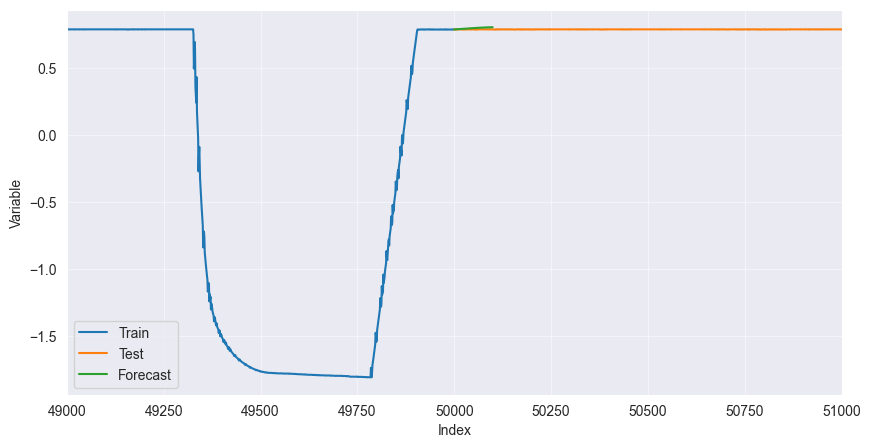

In [109]:
ax = new_df_scaled[49000:].V.plot(figsize=(10,5))
df_scaled[50000:51000+horizon].V.plot(ax=ax)
df_forecast.V.plot(ax=ax)
plt.grid(alpha=0.5, which='both')
plt.xlim(49000, 51000) 
plt.title('prediccion de V')
plt.xlabel('Index')
plt.ylabel('Variable')
plt.legend(['Train', 'Test', 'Forecast'])
plt.show()
#ramp_time
#modeling_thickness

In [18]:
df_forecast.V

0     0.785539
1     0.786150
2     0.785715
3     0.786191
4     0.786259
5     0.787055
6     0.786584
7     0.786702
8     0.786951
9     0.787656
10    0.787239
11    0.787693
12    0.787794
13    0.788243
14    0.787998
15    0.788442
16    0.788556
17    0.789101
18    0.788895
19    0.789133
Name: V, dtype: float64

Voy a probar prediccion inversa

In [103]:
df_autotreat.head(5)

,Timestamp,Time,V,A,T,alloy,voltage,ramp_time,holding_time,area,Imax,modeling_thickness,final_thickness
0,1.687423e+09,2023-06-22 08:31:28,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
1,1.687423e+09,2023-06-22 08:31:29,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
2,1.687423e+09,2023-06-22 08:31:29,0.03,0.01,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
3,1.687423e+09,2023-06-22 08:31:30,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514
4,1.687423e+09,2023-06-22 08:31:31,0.03,0.00,38.1,7075,14,30,20.0,0.5,0.53,0.0,1.204514


In [4]:
def obtener_valores_input(data):
    '''del dataframe orignal obtener V,holndig,ramp para cada final thickness'''
    unique_final_thickness=data['final_thickness'].unique()
    final_thickness=[]
    voltg=[]
    holding=[]
    ramp=[]
    for i in unique_final_thickness:
        a=data[data['final_thickness'] == i]
        len=a.shape[0]
        #obtener los valores de los inputs a mitad de cada salto, aqui es mas fiable
        v=a['voltage'].iloc[round(len/2)]
        h=a['holding_time'].iloc[round(len/2)]
        r=a['ramp_time'].iloc[round(len/2)]
        final_thickness.append(i)
        voltg.append(v)
        holding.append(h)
        ramp.append(r)
    dict={'final_thickness':final_thickness,'Voltage':voltg,'holding_time':holding,'ramp_time':ramp}
    df = pd.DataFrame(dict)
    return df
x_input=obtener_valores_input(df_autotreat)
x_input.head()

,final_thickness,Voltage,holding_time,ramp_time
0,1.204514,14,20.0,30
1,3.659806,14,20.0,60
2,3.633425,14,20.0,60
3,3.382802,14,20.0,30
4,3.478467,14,20.0,30


In [16]:
X = x_input[['Voltage', 'holding_time','ramp_time']] # Habrá que añadir alloy y area si en el futuro tienen variabilidad.
y = x_input[['final_thickness']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=28)

In [17]:
models_and_params = {
        "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "grid_params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": [None] + list(range(10, 31, 10)),
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(random_state=42),
        "grid_params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": list(range(2, 11)),
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.5, 0.8, 1.0],
            "colsample_bytree": [0.5, 0.8, 1.0]
        }},
    "SVM": {
        "model": SVR(),
        "grid_params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf', 'poly'],
            "gamma": ['scale', 'auto']
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "grid_params": {
            "max_depth": [None] + list(range(10, 31, 10)),
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    }
}

In [18]:
for model_name, model_info in models_and_params.items():
    print(f"Grid search for {model_name}...")
    
    # Configurar la búsqueda en cuadrícula
    grid = GridSearchCV(model_info["model"], 
                        model_info["grid_params"], 
                        cv=5, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)
    
    # Entrenar el modelo
    grid.fit(X_train, y_train)
    
    # Mejores parámetros y rendimiento
    best_params = grid.best_params_
    best_score = -grid.best_score_
    
    print(f"Best parameters: {best_params}")
    print(f"Best negative MSE: {best_score}\n")

Grid search for Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best negative MSE: 0.3840967285350866

Grid search for XGBoost...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Best negative MSE: 0.3821232734855227

Grid search for SVM...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best negative MSE: 0.32441516597591674

Grid search for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best negative MSE: 0.45347671911116166



In [93]:
# Optimizar hiperparámetros para el modelo de XGBoost
xgb_grid = GridSearchCV(models_and_params["XGBoost"]["model"], 
                        models_and_params["XGBoost"]["grid_params"], 
                        cv=5, 
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=1)

# Entrenar el modelo
xgb_grid.fit(X_train, y_train)

# Mejores parámetros y rendimiento
best_params_xgb = xgb_grid.best_params_
best_score_xgb = -xgb_grid.best_score_

best_params_xgb, best_score_xgb

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


({'colsample_bytree': 1.0,
  'learning_rate': 0.2,
  'max_depth': 8,
  'n_estimators': 100,
  'subsample': 0.5},
 0.4809854085623971)

In [130]:
xgb_best = xgb.XGBRegressor(**{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0})
xgb_best.fit(X_train, y_train)
r2_xgb = r2_score(y_test, xgb_best.predict(X_test))
pred_vs_test = pd.DataFrame({'Test': y_test['final_thickness'].tolist(),'Pred': xgb_best.predict(X_test).tolist()})
print(pred_vs_test)
r2_xgb


        Test      Pred
0   0.247825  0.470493
1   3.134800  2.495894
2   1.204514  3.585461
3   4.146875  3.949755
4   0.552958  2.495894
5   5.201987  5.501011
6   4.609431  4.429586
7   4.130625  3.949755
8   0.893625  0.672655
9   1.525117  1.852199
10  1.193854  1.061329
11  2.255125  2.132792
12  7.344823  6.820526
13  5.620625  5.680525
14  4.911066  5.118101
15  3.121637  3.643175
16  0.876354  1.018008
17  7.787959  7.869731
18  3.496175  3.173791
19  2.131578  2.260775
20  3.561075  3.173791
21  0.307083  0.470493
22  1.678050  1.852199


0.892411491830915

In [19]:
rf_best = RandomForestRegressor(**{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, random_state=28)
rf_best.fit(X_train, y_train)
rf_pred=rf_best.predict(X_test)
# Evaluar el rendimiento en el conjunto de prueba
r2_rf = r2_score(y_test, rf_pred)

# Mostrar resultados
pred_vs_test_rf = pd.DataFrame({'Test': y_test['final_thickness'].tolist(), 'Pred': rf_pred.tolist()})
print("Random Forest:")
print(pred_vs_test_rf)
print(f"R^2 Score: {r2_rf}\n")

# importances = rf_best.feature_importances_
# feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

Random Forest:
        Test      Pred
0   0.247825  0.337169
1   3.134800  2.603808
2   1.204514  3.581156
3   4.146875  3.975017
4   0.552958  2.603808
5   5.201987  5.345277
6   4.609431  4.524717
7   4.130625  3.975017
8   0.893625  0.392452
9   1.525117  1.827497
10  1.193854  0.983738
11  2.255125  2.211574
12  7.344823  7.368234
13  5.620625  5.553171
14  4.911066  5.997757
15  3.121637  3.568466
16  0.876354  0.773629
17  7.787959  7.996397
18  3.496175  3.000483
19  2.131578  2.202532
20  3.561075  3.000483
21  0.307083  0.337169
22  1.678050  1.827497
R^2 Score: 0.8788922666761196



In [20]:
importances = rf_best.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
print(feature_importances)

        feature  importance
0       Voltage    0.275066
1  holding_time    0.708407
2     ramp_time    0.016527


In [23]:
svr_best = SVR(**{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'})
svr_best.fit(X_train, y_train)
svr_pred=svr_best.predict(X_test)
# Evaluar el rendimiento en el conjunto de prueba
r2_svr = r2_score(y_test, svr_pred)

# Mostrar resultados
pred_vs_test_svr = pd.DataFrame({'Test': y_test['final_thickness'].tolist(), 'Pred': svr_pred.tolist()})
print("Random Forest:")
print(pred_vs_test_svr)
print(f"R^2 Score: {r2_svr}\n")

Random Forest:
        Test      Pred
0   0.247825  0.309953
1   3.134800  1.295033
2   1.204514  3.578357
3   4.146875  4.125440
4   0.552958  1.295033
5   5.201987  5.380619
6   4.609431  4.485648
7   4.130625  4.125440
8   0.893625  0.472982
9   1.525117  1.549134
10  1.193854  1.027290
11  2.255125  2.122905
12  7.344823  7.316173
13  5.620625  5.792797
14  4.911066  4.959534
15  3.121637  3.501985
16  0.876354  0.885211
17  7.787959  7.992088
18  3.496175  3.206804
19  2.131578  2.146680
20  3.561075  3.206804
21  0.307083  0.309953
22  1.678050  1.549134
R^2 Score: 0.9014249090808506



In [132]:
#Prediccion inversa
V_test=X['Voltage'].unique().tolist()
Holding_test=[20., 10.,  5.,  0.,  1.]
Ramp_test=[30,60]
combinaciones = np.array(list(product(V_test, Holding_test,Ramp_test)))#mallado de todas las combinaciones posibles
comb_scalated=scaler.transform(combinaciones)
#esto para a partir de un espesor con pocos decimales sacar el verdadero del dataframe
test_thickness=0.307083
test_espesor_=x_input[(x_input['final_thickness']>test_thickness-0.0005) & (x_input['final_thickness']<test_thickness+0.0005)]
print(test_espesor_['final_thickness'].iloc[0])

0.307083333333333


In [133]:
pred=rf_best.predict(comb_scalated)

In [134]:
diferencias_absolutas = np.abs(pred - test_thickness)

#índice del valor mínimo
indice_valor_minimo = np.argmin(diferencias_absolutas)
valor_mas_cercano = pred[indice_valor_minimo]

print('El valor mas cercano es: ',valor_mas_cercano,'El valor esperado es: ',test_thickness)
inputs = scaler.inverse_transform([comb_scalated[indice_valor_minimo]])
print('Los inputs calculados son: ',inputs)
print('Los inputs reales son: ')
#x_input[x_input['final_thickness']==1.2045138888888722]
test_espesor_


El valor mas cercano es:  0.30788739583333324 El valor esperado es:  0.307083
Los inputs calculados son:  [[14.  0. 30.]]
Los inputs reales son: 


,final_thickness,Voltage,holding_time,ramp_time
50,0.307083,14,0.0,60


In [135]:
#lo mismo pero solo con los valores que hemos usado en el modelo
X.values
new_pred=rf_best.predict(X_scaled)
new_diferencias_absolutas = np.abs(new_pred - test_thickness)

#índice del valor mínimo
new_indice_valor_minimo = np.argmin(new_diferencias_absolutas)
new_valor_mas_cercano = new_pred[new_indice_valor_minimo]
print('El valor mas cercano es: ',new_valor_mas_cercano,'El valor esperado es: ',test_thickness)
inputs = X.values[new_indice_valor_minimo,]#scaler.inverse_transform([X_scaled[indice_valor_minimo]])
print('Los inputs calculados son: ',inputs)
print('Los inputs reales son: ')
#x_input[x_input['final_thickness']==1.2045138888888722]
test_espesor_

El valor mas cercano es:  0.30788739583333324 El valor esperado es:  0.307083
Los inputs calculados son:  [14.  0. 60.]
Los inputs reales son: 


,final_thickness,Voltage,holding_time,ramp_time
50,0.307083,14,0.0,60


In [86]:

scaler.inverse_transform([X_test[21]])
X.values[3,]

array([14., 20., 30.])

Ahora vamos a comparar los resultados de y_test: valor real, el predicho por estas predicciones inversas (pred) y lo mismo teniendo solo en cuenta 
los valores del modelo (new_pred)

In [136]:
pred_thickness=[]
new_pred_thickness=[]
inputs=np.array([])
new_inputs=np.array([])
for i in y_test['final_thickness']:
    #predicciones con mallado
    diferencias_absolutas = np.abs(pred - i)
    indice_valor_minimo = np.argmin(diferencias_absolutas)
    valor_mas_cercano = pred[indice_valor_minimo]
    pred_thickness.append(valor_mas_cercano)
    #predicciones solo con las del modelo
    new_diferencias_absolutas = np.abs(new_pred - i)
    new_indice_valor_minimo = np.argmin(new_diferencias_absolutas)
    new_valor_mas_cercano = new_pred[new_indice_valor_minimo]
    new_pred_thickness.append(new_valor_mas_cercano)
    if inputs.size == 0:
        inputs = comb_scalated[indice_valor_minimo]
    else:
        inputs = np.vstack((inputs, comb_scalated[indice_valor_minimo]))
    if new_inputs.size == 0:
        new_inputs = X.values[new_indice_valor_minimo,]
    else:
        new_inputs = np.vstack((new_inputs, X.values[new_indice_valor_minimo,]))
    
    
inputs_rescaled = scaler.inverse_transform(inputs)
pred_V=inputs_rescaled[:,0]
pred_H=inputs_rescaled[:,1]
pred_R=inputs_rescaled[:,2]

new_pred_V=new_inputs[:,0]
new_pred_H=new_inputs[:,1]
new_pred_R=new_inputs[:,2]
#inputs.reshape(-1, 3)

'''
print('El valor mas cercano es: ',valor_mas_cercano,'El valor esperado es: ',test_thickness)
inputs = scaler.inverse_transform([comb_scalated[indice_valor_minimo]])'''

"\nprint('El valor mas cercano es: ',valor_mas_cercano,'El valor esperado es: ',test_thickness)\ninputs = scaler.inverse_transform([comb_scalated[indice_valor_minimo]])"

In [138]:
inverse_pred=pd.DataFrame({'Pred_Thickness':pred_thickness,'Pred_V':pred_V,'Pred_H':pred_H,'Pred_R':pred_R})
inverse_new_pred=pd.DataFrame({'New_Pred_Thickness':new_pred_thickness,'New_Pred_V':new_pred_V,'New_Pred_H':new_pred_H
                               ,'New_Pred_R':new_pred_R})
real_inputs=scaler.inverse_transform(X_test[:])
inverse_REAL=pd.DataFrame({'Real_Thickness':y_test['final_thickness'],'Real_V':real_inputs[:,0],'Real_Holding':real_inputs[:,1]
                                       ,'Real_Ramp':real_inputs[:,2]}).reset_index(drop=True)
inverse_comparacion = pd.concat([inverse_REAL, inverse_pred,inverse_new_pred], axis=1)
inverse_comparacion.head()

,Real_Thickness,Real_V,Real_Holding,Real_Ramp,Pred_Thickness,Pred_V,Pred_H,Pred_R,New_Pred_Thickness,New_Pred_V,New_Pred_H,New_Pred_R
0,0.247825,14.0,0.0,60.0,0.307887,14.0,0.0,30.0,0.307887,14.0,0.0,60.0
1,3.134800,22.0,0.0,60.0,3.129357,18.0,10.0,30.0,3.129357,18.0,10.0,30.0
2,1.204514,14.0,20.0,30.0,1.180527,18.0,0.0,30.0,1.180527,18.0,0.0,60.0
3,4.146875,18.0,10.0,30.0,4.460741,20.0,10.0,60.0,4.460741,20.0,10.0,60.0
4,0.552958,22.0,0.0,60.0,0.532447,16.0,0.0,30.0,0.532447,16.0,0.0,60.0


In [124]:
df_autotreat['voltage'].unique()
print(x_input[(x_input['Voltage']==18.00) & (x_input['holding_time']==10.0)].final_thickness.iloc[0])
x_input['final_thickness'].iloc[51]
df_autotreat[df_autotreat['final_thickness']==4.103187499999577]

4.103187499999577


,Timestamp,Time,V,A,T,alloy,voltage,ramp_time,holding_time,area,Imax,modeling_thickness,final_thickness
140771,1.689065e+09,2023-07-11 08:48:00,0.01,0.0,38.6,7075,18,60,10.0,0.5,1.77,0.000000,4.103187
140772,1.689065e+09,2023-07-11 08:48:00,0.01,0.0,38.6,7075,18,60,10.0,0.5,1.77,0.000000,4.103187
140773,1.689065e+09,2023-07-11 08:48:00,0.01,0.0,38.6,7075,18,60,10.0,0.5,1.77,0.000000,4.103187
140774,1.689065e+09,2023-07-11 08:48:00,0.01,0.0,38.6,7075,18,60,10.0,0.5,1.77,0.000000,4.103187
140775,1.689065e+09,2023-07-11 08:48:01,0.01,0.0,38.6,7075,18,60,10.0,0.5,1.77,0.000000,4.103187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146202,1.689067e+09,2023-07-11 09:10:59,0.01,0.0,38.3,7075,18,60,10.0,0.5,1.77,4.099837,4.103187
146203,1.689067e+09,2023-07-11 09:10:59,0.01,0.0,38.3,7075,18,60,10.0,0.5,1.77,4.100675,4.103187
146204,1.689067e+09,2023-07-11 09:10:59,0.01,0.0,38.3,7075,18,60,10.0,0.5,1.77,4.101512,4.103187
146205,1.689067e+09,2023-07-11 09:10:59,0.01,0.0,38.3,7075,18,60,10.0,0.5,1.77,4.102350,4.103187


In [15]:
#print(x_input[(x_input['Voltage']==20.00) & (x_input['holding_time']==20.0)])
print(x_input[(x_input['Voltage']==18.00) & (x_input['holding_time']==10.0) & (x_input['ramp_time']==30.0)])
print(x_input[(x_input['Voltage']==22.00) & (x_input['holding_time']==0.0) & (x_input['ramp_time']==60.0)])
#x_input.groupby('holding_time').head(5)

     final_thickness  Voltage  holding_time  ramp_time
105         4.130625       18          10.0         30
106         4.146875       18          10.0         30
107         4.225625       18          10.0         30
    final_thickness  Voltage  holding_time  ramp_time
61         0.552958       22           0.0         60
62         3.112675       22           0.0         60
63         3.134800       22           0.0         60
